In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import earthpy.plot as ep
import earthpy.spatial as es
import matplotlib.pyplot as plt
from rasterio.mask import mask
from sklearn.cluster import KMeans
import folium
import branca.colormap as cm
import glob

In [2]:
# Load raster bands from folder
landsat_2014_bands = sorted(glob.glob("C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/L832014/*B[2-7]*.tif"))
landsat_2024_bands = sorted(glob.glob("C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/L812024/*B[2-7]*.tif"))

In [3]:
print(f"2014 Bands Loaded: {len(landsat_2014_bands)}")  # Should be 6
print(f"2024 Bands Loaded: {len(landsat_2024_bands)}")  # Should be 6

2014 Bands Loaded: 6
2024 Bands Loaded: 6


In [4]:
# Function to load and stack bands
def stack_raster(bands, output_path):
    src_files_to_mosaic = [rasterio.open(band) for band in bands]
    meta = src_files_to_mosaic[0].meta.copy()
    meta.update(count=len(bands))
    
    with rasterio.open(output_path, 'w', **meta) as dest:
        for i, src in enumerate(src_files_to_mosaic, start=1):
            dest.write(src.read(1), i)
    return output_path

In [5]:
# Function to clip raster
def clip_raster(raster_path, shapefile_path, output_path):
    raster = rasterio.open(raster_path)
    shape = gpd.read_file(shapefile_path)
    shape = shape.to_crs(raster.crs)
    
    geometry = shape.geometry.values[0]
    out_image, out_transform = mask(raster, [geometry], crop=True)
    
    meta = raster.meta.copy()
    meta.update({"height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})
    
    with rasterio.open(output_path, "w", **meta) as dest:
        dest.write(out_image)
    return output_path

In [6]:
# Function to calculate NDVI
def calculate_ndvi(nir_band, red_band):
    return (nir_band - red_band) / (nir_band + red_band)

In [7]:
# Function to calculate WDI
def calculate_wdi(nir_band, swir_band):
    return (nir_band - swir_band) / (nir_band + swir_band)

In [8]:
# Stack raster bands
landsat_2014 = stack_raster(landsat_2014_bands, "stacked_2014.tif")
landsat_2024 = stack_raster(landsat_2024_bands, "stacked_2024.tif")

In [9]:
# Clip to area of interest Bulawayo
aoi_path = "C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/Bulawayo_Shapefile/Bulawayo.shp"
clipped_2014 = clip_raster(landsat_2014, aoi_path, "clipped_2014.tif")
clipped_2024 = clip_raster(landsat_2024, aoi_path, "clipped_2024.tif")

In [10]:
# Read raster data for analysis
with rasterio.open(clipped_2014) as src:
    red_2014, nir_2014, swir_2014 = src.read(3), src.read(4), src.read(5)

with rasterio.open(clipped_2024) as src:
    red_2024, nir_2024, swir_2024 = src.read(3), src.read(4), src.read(5)

In [11]:
# Calculate NDVI and WDI
ndvi_2014 = calculate_ndvi(nir_2014, red_2014)
ndvi_2024 = calculate_ndvi(nir_2024, red_2024)
ndvi_change = ndvi_2024 - ndvi_2014

wdi_2014 = calculate_wdi(nir_2014, swir_2014)
wdi_2024 = calculate_wdi(nir_2024, swir_2024)
wdi_change = wdi_2024 - wdi_2014

C:\Users\User\AppData\Local\Temp\ipykernel_11916\3250735510.py:3: RuntimeWarning: invalid value encountered in divide
  return (nir_band - red_band) / (nir_band + red_band)


In [12]:
def kmeans_classification(image, n_clusters=5):
    # Mask out NaN values
    nan_mask = np.isnan(image)
    
    # Flatten and remove NaN values
    valid_pixels = image[~nan_mask].reshape(-1, 1)
    
    # Apply KMeans only on valid pixels
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels = kmeans.fit_predict(valid_pixels)
    
    # Reconstruct classified image with NaN values
    classified_image = np.full(image.shape, np.nan)
    classified_image[~nan_mask] = labels
    
    return classified_image

# Apply classification
classified_2014 = kmeans_classification(ndvi_2014)
classified_2024 = kmeans_classification(ndvi_2024)

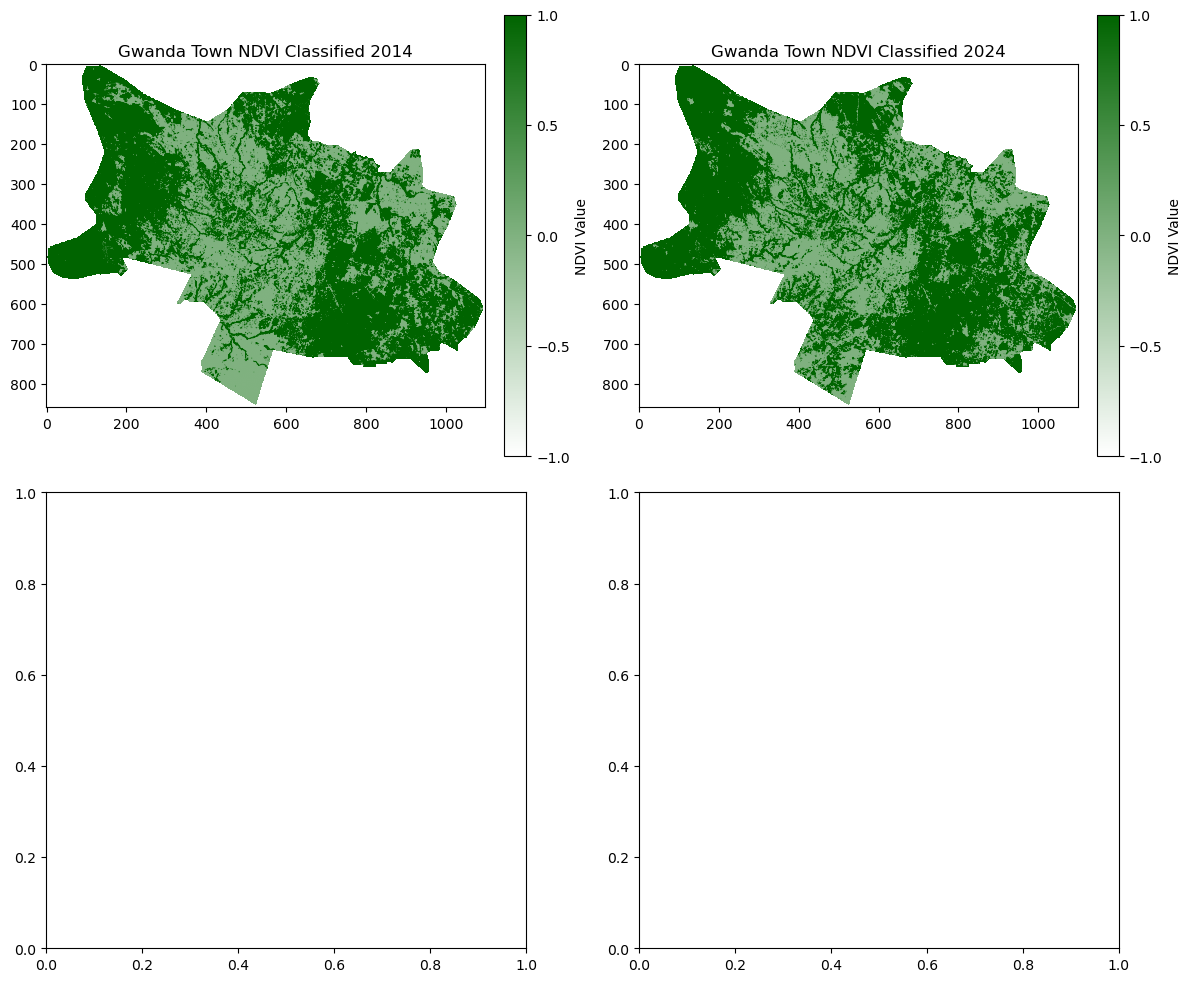

In [13]:
import matplotlib.colors as mcolors

# Define custom colormaps
ndvi_cmap = mcolors.LinearSegmentedColormap.from_list("ndvi", ["white", "darkgreen"])

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot NDVI Classification with custom colormap and fixed range (-1 to 1)
ndvi_plot_2014 = ax[0, 0].imshow(classified_2014, cmap=ndvi_cmap, vmin=-1, vmax=1)
ndvi_plot_2024 = ax[0, 1].imshow(classified_2024, cmap=ndvi_cmap, vmin=-1, vmax=1)
ax[0, 0].set_title("Gwanda Town NDVI Classified 2014")
ax[0, 1].set_title("Gwanda Town NDVI Classified 2024")

# Add colorbars
cbar_2014 = fig.colorbar(ndvi_plot_2014, ax=ax[0, 0], fraction=0.046, pad=0.04)
cbar_2024 = fig.colorbar(ndvi_plot_2024, ax=ax[0, 1], fraction=0.046, pad=0.04)

# Set colorbar range explicitly from -1 to 1
cbar_2014.set_ticks(np.linspace(-1, 1, 5))  # Adjust number of ticks as needed
cbar_2024.set_ticks(np.linspace(-1, 1, 5))

# Set colorbar labels
cbar_2014.set_label("NDVI Value")
cbar_2024.set_label("NDVI Value")

plt.tight_layout()
plt.show()


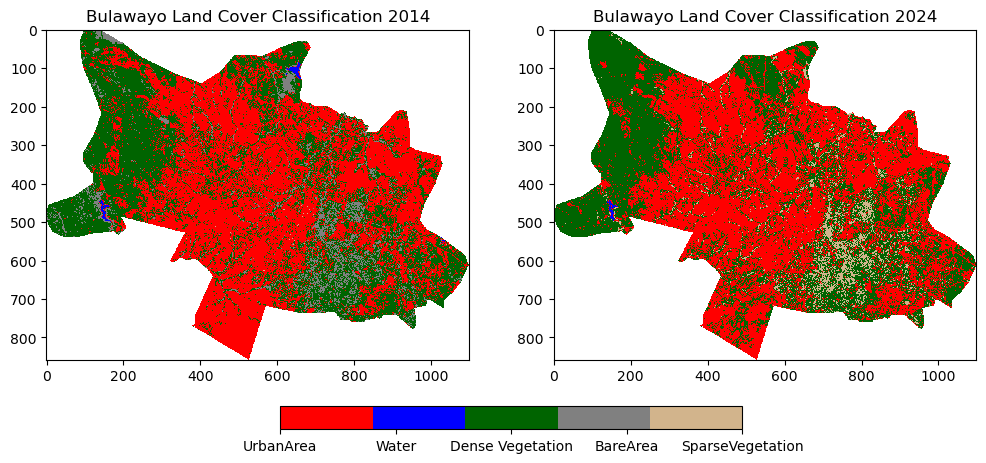

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import earthpy.plot as ep

# Define a custom colormap for land cover classes
landcover_cmap = mcolors.ListedColormap([
    "red",  # Class 0: UrbanArea
    "blue",  # Class 1: Water
    "darkgreen",  # Class 2: Dense Vegetation
    "gray",  # Class 3: BareArea
    "tan"  # Class 4: SparseVegetation
])

# Define class labels
class_labels = ["UrbanArea", "Water", "Dense Vegetation", "BareArea", "SparseVegetation"]

# Create a figure with two subplots for 2014 and 2024
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the classified images with a color legend
im1 = ax[0].imshow(classified_2014, cmap=landcover_cmap, interpolation='nearest')
ax[0].set_title("Bulawayo Land Cover Classification 2014")

im2 = ax[1].imshow(classified_2024, cmap=landcover_cmap, interpolation='nearest')
ax[1].set_title("Bulawayo Land Cover Classification 2024")

# Add a colorbar legend
cbar = fig.colorbar(im2, ax=ax, orientation="horizontal", fraction=0.05, pad=0.1)
cbar.set_ticks(range(5))  # Set ticks for 5 classes
cbar.set_ticklabels(class_labels)  # Set class names

# Display the plots
plt.show()
